## Install Requirements
******Remember to restart the kernel after installing

In [3]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.1
    Uninstalling pip-23.1.1:
      Successfully uninstalled pip-23.1.1
Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

## Process the videos into frames

In [5]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where the name of the folder is the name of the video
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isleak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    count = range[0]
    start = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    X_design = []

    fgbg = cv2.createBackgroundSubtractorMOG2()

    if vidcap.isOpened():
      while success and count < range[1]:
          vidcap.set(cv2.CAP_PROP_POS_MSEC, (start*1000))    # added this line 
          success, image = vidcap.read()
          if success:
            print ('Read a new frame: ', count, " ,isleak: ", isleak)
            label = 0

            # extract foreground mask
            fgmask = fgbg.apply(image)

            fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8))

            # cv2_imshow(image)
            # cv2_imshow(fgmask) # debugging

            # image = cv2.cvtColor(fgmask, cv2.COLOR_BGR2GRAY) # convert to grayscale
            image = fgmask.reshape(*(fgmask.shape), 1)

            if isleak:
              cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % count), image)     # save frame as JPEG file
              label = 1
            else:
              cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % count), image)
            X_design.append(np.array(image))
            count += 1
            start += 1
          else:
            break
      vidcap.release()
    cv2.destroyAllWindows()
    return np.stack(X_design)
  # call helper for both leak and nonleak
  X_leak = helper(pathIn, leakPath, leakRange, True)
  y_leak = np.ones(X_leak.shape[0])
  X_nonleak = helper(pathIn, nonleakPath, nonleakRange, False)
  y_nonleak = np.zeros(X_nonleak.shape[0])

  X = np.concatenate((X_leak, X_nonleak), axis=0)
  y = np.concatenate((y_leak, y_nonleak), axis=0)
  
  return X, y

### Get the images now

In [6]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

In [7]:
raw_data = np.loadtxt(os.path.join(dir_path, 'leak_range.csv'), skiprows=1, delimiter=',', dtype=int)

nonleak_range = dict(zip(raw_data[:, 0], raw_data[:, 1:3]))

In [8]:
def read_frames_from_dir(dir_path, output_path, image_dim, max_vids=None):
    cur_count = 1
    X_train, y_train = np.array([], dtype=np.int64).reshape(0, image_dim[0], image_dim[1], 1), []
    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(os.path.basename(vid_path)[4:8])

        nonleak_start = 1
        nonleak_end = nonleak_range[vid_id][0]
        leak_start = nonleak_end + 1
        leak_end = nonleak_range[vid_id][1]

        X_vid, y_vid = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end))
        print(X_vid.shape)
        X_train = np.concatenate((X_train, X_vid), axis=0)
        y_train.append(y_vid)
        print('done', cur_count)
        cur_count += 1
    y_train = np.concatenate(y_train, axis=0) # improve time complexity
    return X_train, y_train

In [9]:
image_dim = (240, 320)
vid_count = 4
test_count = 1

X_train, y_train = read_frames_from_dir(train_data_dir, frame_train_data_dir, image_dim, vid_count)
X_test, y_test = read_frames_from_dir(test_data_dir, frame_test_data_dir, image_dim, test_count)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Read a new frame:  211  ,isleak:  True
Read a new frame:  212  ,isleak:  True
Read a new frame:  213  ,isleak:  True
Read a new frame:  214  ,isleak:  True
Read a new frame:  215  ,isleak:  True
Read a new frame:  216  ,isleak:  True
Read a new frame:  217  ,isleak:  True
Read a new frame:  218  ,isleak:  True
Read a new frame:  219  ,isleak:  True
Read a new frame:  220  ,isleak:  True
Read a new frame:  221  ,isleak:  True
Read a new frame:  222  ,isleak:  True
Read a new frame:  223  ,isleak:  True
Read a new frame:  224  ,isleak:  True
Read a new frame:  225  ,isleak:  True
Read a new frame:  226  ,isleak:  True
Read a new frame:  227  ,isleak:  True
Read a new frame:  228  ,isleak:  True
Read a new frame:  229  ,isleak:  True
Read a new frame:  230  ,isleak:  True
Read a new frame:  231  ,isleak:  True
Read a new frame:  232  ,isleak:  True
Read a new frame:  233  ,isleak:  True
Read a new frame:  234  ,isleak:  True
Read a new frame:  235  ,isleak:  True
Read a new frame:  236  ,

((6047, 240, 320, 1), (6047,), (1487, 240, 320, 1), (1487,))

In [10]:
from keras import layers 
from keras import models 

model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 320, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 38, 128)      0

In [11]:
from keras import optimizers 

model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-3), metrics=['acc'])

In [12]:
X_train.shape

(6047, 240, 320, 1)

In [13]:
y_train.shape

(6047,)

In [14]:
X_train[0]

array([[[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]],

       [[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]],

       [[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]],

       ...,

       [[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]],

       [[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]],

       [[127],
        [127],
        [127],
        ...,
        [127],
        [127],
        [127]]])

In [15]:
val_split = 0.2
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)

X = np.concatenate((X_t, X_v))
y = np.concatenate((y_t, y_v))

In [16]:
nonleaks = len(y) - sum(y)
leaks = sum(y)
total = len(y)

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)

class_weight = {0: weight_nonleak, 1: weight_leak}

In [17]:
class_weight

{0: 3.696210268948655, 1: 0.5782176324344999}

In [18]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# for now, dont do augmentation
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
#     horizontal_flip=True,
#     shear_range=0.2,
#     zoom_range=0.05,
)

train_datagen.fit(X)

train_flow = train_datagen.flow(
    X, y, 
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='training'
)

val_flow = train_datagen.flow(
    X, y, 
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='validation'
)

In [19]:
num_epochs = 10

history = model.fit_generator(
    train_flow, 
    epochs=10, 
    validation_data=val_flow, 
    validation_steps=1,
    class_weight=class_weight
)


model.save('leak_and_nonleak_roy.h5')

Epoch 1/10


/var/folders/0z/b4wxymw136bgfx2h57cr9nbh0000gn/T/ipykernel_23685/2424428957.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-04-26 03:49:19.587601: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


152/152 [==============================] - 97s 636ms/step - loss: 0.6009 - acc: 0.8497 - val_loss: 0.4594 - val_acc: 0.7500
Epoch 2/10
152/152 [==============================] - 105s 692ms/step - loss: 0.5327 - acc: 0.8280 - val_loss: 0.3924 - val_acc: 0.8438
Epoch 3/10
152/152 [==============================] - 98s 642ms/step - loss: 0.4916 - acc: 0.8198 - val_loss: 0.3030 - val_acc: 0.8750
Epoch 4/10
152/152 [==============================] - 97s 634ms/step - loss: 0.4635 - acc: 0.8187 - val_loss: 0.4284 - val_acc: 0.6875
Epoch 5/10
152/152 [==============================] - 103s 679ms/step - loss: 0.4426 - acc: 0.8140 - val_loss: 0.4018 - val_acc: 0.7500
Epoch 6/10
152/152 [==============================] - 99s 651ms/step - loss: 0.4257 - acc: 0.8123 - val_loss: 0.2479 - val_acc: 0.8750
Epoch 7/10
152/152 [==============================] - 100s 659ms/step - loss: 0.4093 - acc: 0.8103 - val_loss: 0.3806 - val_acc: 0.7500
Epoch 8/10
152/152 [==============================] - 106s 695m

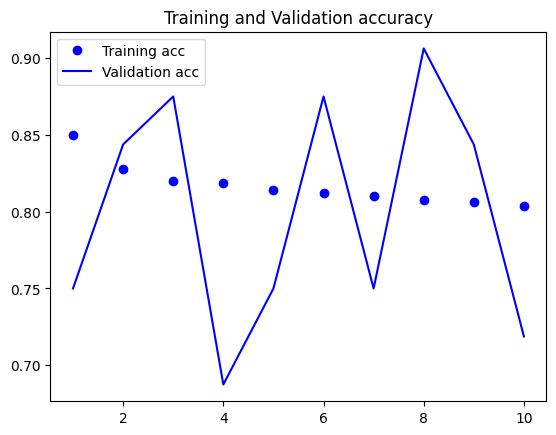

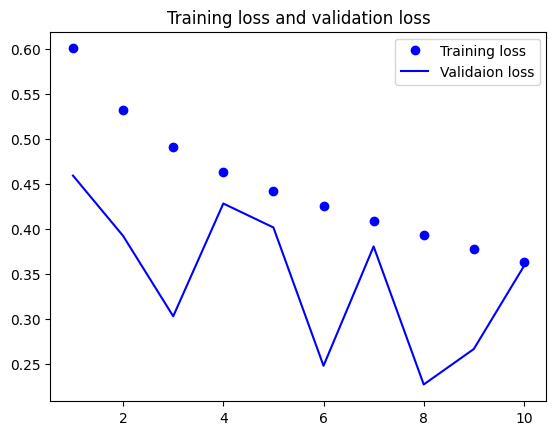

In [20]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.show() 

## Testing

In [21]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_datagen.fit(X_test)

test_flow = test_datagen.flow(
    X_test,
    batch_size=batch_size,
    shuffle=False,
    
)

In [23]:
predictions = model.predict(test_flow)

47/47 [==============================] - 9s 188ms/step


In [27]:
processed_preds = (predictions >= 0.5).flatten().astype(int)

In [29]:
test_acc = np.sum(processed_preds == y_test) / len(y_test)
print(f'Test Accuracy is {test_acc} after training for {num_epochs} epochs on {len(y_test)} test images')

Test Accuracy is 0.7101546738399462 after training for 10 epochs on 1487 test images


## Below is legacy code appendix

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,       #
    width_shift_range=0.2,   # 
    height_shift_range=0.2,  # 
    shear_range=0.2,         # 
    zoom_range=0.2,          # 
    horizontal_flip=True,    # 
    fill_mode='nearest'      # 
)

# 
from keras.preprocessing import image 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]  # 
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.reshape((1, ) + x.shape)  # 

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i) 
    i += 1
    imgplot = plt.imshow(array_to_img(batch[0])) 
    if i % 4 == 0:
        break 
plt.show() 

In [ ]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

history = model.fit_generator(  
    
    train_generator, 
    steps_per_epoch=1, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=1
)

# Save
model.save('leak_and_nonleak_2.h5') 

In [ ]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show() 

In [ ]:
f1 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame3018.jpg'  # nonleak
f2 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame4414.jpg'  # leak

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

img_path = f2
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.astype('float32') / 255
x = x.reshape((1, ) + x.shape)  # 

res = model.predict(x)  # 
leak_acc = 1 - res[0][0]
leak_acc

In [ ]:
import matplotlib.pyplot as plt 
from keras.preprocessing import image 
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

model = load_model('./leak_and_nonleak_2.h5')
image_path = r'./test/frame4404.jpg'  # 
original_image = load_img(image_path)

img = load_img(image_path, target_size=(150, 150))
x = img_to_array(img) 
x = x.astype('float32') / 255 
x = x.reshape((1, ) + x.shape) 

res = model.predict(x)
res = res[0][0]
acc = 1- res

text = 'leak'
if res > 0.5:
    text = 'nonleak'
plt.imshow(original_image)
plt.axis("off")
plt.text(30, 40, text, fontdict=dict(fontsize=30, color='r',
            family='monospace',#
            weight='bold',#
            )#
)
plt.show()

In [ ]:
acc